In [ ]:
# Web-Scraping and Python Project, Aug 2018


### Import Packages and Data

In [168]:
# Import packages
from datetime import datetime
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import plotly as ptly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.plotly as py
import re
import seaborn as sns
from scipy import stats
from sklearn import linear_model
%matplotlib inline
pd.set_option('display.max_columns', None) # show all columns
sns.set()
pal = sns.dark_palette("palegreen", as_cmap=True)

In [ ]:
# Get plotly api keys
%load ref_keys.py
from ref_keys.py import api_key, plotly_api_key


In [170]:
# Import data for all records
raw_df = pd.read_csv('./csv/tripadvisor_reviews_20180803_1412.csv')
# Save second version to work with
df = raw_df
# Drop alliance column (not populated and merged in later)
del df['alliance']
# Format review_date, add review_month (can also add year_mo...)
df['review_date'] = pd.to_datetime(df.review_date)
df['review_month'] = df.apply(lambda x: x['review_date'].month, axis=1)
df.head(100)

,airline_name,airline_nbr_reviews,airline_stars,airline_stars_checkin_and_boarding,airline_stars_cleanliness,airline_stars_customer_service,airline_stars_food_beverage,airline_stars_inflight_entertain,airline_stars_legroom,airline_stars_seat_comfort,airline_stars_value_for_money,record_nbr,review_ID,review_cabin_class,review_date,review_destination,review_domestic_intl,review_helpful_votes,review_origin,review_stars,review_text,review_title,review_travel_tip,review_via_mobile,reviewer_city,reviewer_country,reviewer_helpful_votes,reviewer_level,reviewer_name,reviewer_nbr_reviews,review_month
0,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602239156,Economy,2018-08-02,Newark,International,NaN,Sao Paulo,4.0,We flew economy plus. The ground crew was good...,Excellent Service at the gate and on the plane,NaN,NaN,NaN,NaN,NaN,3.0,Nick M,11.0,8
1,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602237003,Economy,2018-08-02,Newark,International,NaN,Dublin,1.0,Absolutely zero customer service. No screens t...,Not impressed,NaN,viaMobile,Belfast,United Kingdom,13.0,3.0,Lynne K,18.0,8
2,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602235228,Economy,2018-08-02,Mexico City,Mexico,NaN,Los Angeles,4.0,No hitches. On time. Comfortable. There always...,Just fine,NaN,NaN,NaN,NaN,NaN,NaN,hawk39,2.0,8
3,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602228223,Economy,2018-08-02,Detroit,USA,NaN,Ottawa,2.0,Arrived at the airport 4 for 6 am flight. Canc...,Cancelled two day in a row,NaN,NaN,NaN,NaN,NaN,NaN,Liz E,2.0,8
4,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602224401,Economy,2018-08-02,Newark,Domestic,NaN,Charlotte,1.0,It is abundantly clear that no person who work...,Avoid United Airlines At All Cost,NaN,viaMobile,River Vale,New Jersey,NaN,NaN,wjoshuala...,1.0,8
5,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602213010,Economy,2018-08-02,Chicago,International,NaN,Rome,3.0,"Seats were fairly comfortable, servers were fr...",10 hour flight with only one smallish meal and...,NaN,NaN,Mek'ele,Ethiopia,32.0,6.0,Kristi N,116.0,8
6,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602210829,Economy,2018-08-02,San Francisco,Domestic,NaN,Fort Lauderdale,1.0,Wish the seats were stationery as your book en...,If you wish to feel like a sardine fly this plane,NaN,viaMobile,Weston,Florida,3.0,3.0,LIRA P,18.0,8
7,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602208584,Economy,2018-08-02,Orlando,Domestic,NaN,Newark,1.0,united deserves a zeroon 1/7/18 i booked a fam...,united deserves a zero,NaN,viaMobile,Emerson,New Jersey,12.0,3.0,njtripdad,22.0,8
8,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602196100,Economy,2018-08-02,Houston,International,1.0,Munich,3.0,I always fly United and in general I am happy ...,Vacation,NaN,viaMobile,NaN,NaN,18.0,4.0,Hossein T,33.0,8
9,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602193514,Economy,2018-08-02,Dallas,Domestic,NaN,Los Angeles,4.0,couldn't take a carry on bag..and got middle s...,I will pay more next time..,NaN,viaMobile,Compton,California,NaN,NaN,krzy4purp...,2.0,8


In [4]:
# Get # rows and columns of df
df.shape
#38k rows, 33 cols

(38430, 31)

In [5]:
# Shorten airline name
# Column for shortened airline name
df['airline_name_short'] = df['airline_name']

# Strip out the 'Airlines'/'Air Lines'/etc. from airline name
for airline in ['Airlines', 'Air Lines', 'Airways', 'Royal Dutch']:
    df.loc[df['airline_name_short'].str.contains\
               (airline), 'airline_name_short'] \
= df.apply(lambda x: x['airline_name_short'].split(airline,1)[0].strip(), axis=1)

# Add flag for four big U.S. airlines
big_four = ['American','Delta','United','Southwest']
df['big_four'] = np.where(df['airline_name_short'].isin(big_four), 1, 0)
    
# See data
df.head()

,airline_name,airline_nbr_reviews,airline_stars,airline_stars_checkin_and_boarding,airline_stars_cleanliness,airline_stars_customer_service,airline_stars_food_beverage,airline_stars_inflight_entertain,airline_stars_legroom,airline_stars_seat_comfort,airline_stars_value_for_money,record_nbr,review_ID,review_cabin_class,review_date,review_destination,review_domestic_intl,review_helpful_votes,review_origin,review_stars,review_text,review_title,review_travel_tip,review_via_mobile,reviewer_city,reviewer_country,reviewer_helpful_votes,reviewer_level,reviewer_name,reviewer_nbr_reviews,review_month,airline_name_short,big_four
0,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602239156,Economy,2018-08-02,Newark,International,NaN,Sao Paulo,4.0,We flew economy plus. The ground crew was good...,Excellent Service at the gate and on the plane,NaN,NaN,NaN,NaN,NaN,3.0,Nick M,11.0,8,United,1
1,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602237003,Economy,2018-08-02,Newark,International,NaN,Dublin,1.0,Absolutely zero customer service. No screens t...,Not impressed,NaN,viaMobile,Belfast,United Kingdom,13.0,3.0,Lynne K,18.0,8,United,1
2,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602235228,Economy,2018-08-02,Mexico City,Mexico,NaN,Los Angeles,4.0,No hitches. On time. Comfortable. There always...,Just fine,NaN,NaN,NaN,NaN,NaN,NaN,hawk39,2.0,8,United,1
3,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602228223,Economy,2018-08-02,Detroit,USA,NaN,Ottawa,2.0,Arrived at the airport 4 for 6 am flight. Canc...,Cancelled two day in a row,NaN,NaN,NaN,NaN,NaN,NaN,Liz E,2.0,8,United,1
4,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602224401,Economy,2018-08-02,Newark,Domestic,NaN,Charlotte,1.0,It is abundantly clear that no person who work...,Avoid United Airlines At All Cost,NaN,viaMobile,River Vale,New Jersey,NaN,NaN,wjoshuala...,1.0,8,United,1


In [6]:
# Data to join
# Lookup used in webscraping, repurposed for this analysis (to add in alliance, budget, etc.)
airline_list = [# Airlines with >10k reviews on tripadvisor
                ['airline_name', 'url_nbr_tripadvisor', 'nbr_pages_scrape', 'country', 'airline_counter', 'alliance', 'budget'],
                ['Air Canada', 8728998, 1, 'Canada',1,'Star Alliance','Not Budget'], 
                ['United Airlines', 8729177, 860, 'United States',2,'Star Alliance','Not Budget'], 
                ['American Airlines', 8729020, 1175, 'United States',3,'OneWorld','Not Budget'], 
                ['Delta Air Lines', 8729060, 995, 'United States',4,'Skyteam','Not Budget'],
                ['Southwest Airlines',8729156,895, 'United States',5,'N/A','Budget'],
                ['Ryanair', 8729141, 1, 'Ireland',6,'N/A', 'Budget'],
                ['Transavia',8729171,1, 'Netherlands',7,'N/A', 'Budget'], # KLM's Budget
                ['Emirates',8729069,1, 'United Arab Emirates',8,'N/A', 'Not Budget'],
                ['British Airways',8729039,1, 'England',9,'OneWorld', 'Not Budget'],
                ['easyJet',8729066,1, 'England',10,'N/A', 'Budget'], # British Budget
                ['LATAM Airlines',10290698,1, 'Chile',11,'OneWorld', 'Not Budget'],
                ['Lufthansa',8729113,1, 'Germany',12,'Star Alliance', 'Not Budget'],
                ['Air France',8729003,1, 'France',13,'Skyteam', 'Not Budget'],
                ['KLM Royal Dutch Airlines',8729104,1, 'Netherlands',14,'Skyteam', 'Not Budget'],
                ['Qatar Airways',8729134,1, 'Qatar',15,'OneWorld', 'Not Budget'],
                ['Turkish Airlines',8729174,1, 'Turkey',16,'Star Alliance', 'Not Budget'],
                ['Vueling Airlines',8729185,1, 'Spain',17,'N/A', 'Budget'],
                ['Norwegian',8729125,1, 'Norway',17,'N/A', 'Budget'],
                ['Singapore Airlines',8729151,1, 'Singapore',19,'Star Alliance', 'Not Budget'],
                ['Jet2.com',8729098,1, 'England',20,'N/A', 'Budget'],
                ['GOL Airlines',8729083,1, 'Brazil',21,'N/A', 'Budget'],
                ['Alitalia',8729018,1, 'Italy',22,'Skyteam', 'Not Budget'],
                ['Qantas',8729133,1, 'Australia',23,'OneWorld', 'Not Budget'],
                ['Iberia',8729089,1, 'Spain',24,'OneWorld', 'Not Budget'],
                ['TAP Portugal',8729164,1, 'Portugal',25,'Star Alliance', 'Not Budget'],
                ['Azul',8728972,1, 'Brazil',26,'N/A', 'Budget'],
                ['Etihad Airways',8729074,1, 'United Arab Emirates',27,'N/A', 'Not Budget'],
                ['JetBlue',8729099,1, 'United States',28,'N/A', 'Budget'],
                ['Cathay Pacific',8729046,1, 'China',29,'OneWorld', 'Not Budget']
               ]
# United end: 860, American end: 1175, Delta end: 995, Southwest end: 895

In [7]:
# Turn airline_list into dataframe
airline_ref_df = pd.DataFrame(airline_list[1:],columns=airline_list[0])
airline_ref_df

,airline_name,url_nbr_tripadvisor,nbr_pages_scrape,country,airline_counter,alliance,budget
0,Air Canada,8728998,1,Canada,1,Star Alliance,Not Budget
1,United Airlines,8729177,860,United States,2,Star Alliance,Not Budget
2,American Airlines,8729020,1175,United States,3,OneWorld,Not Budget
3,Delta Air Lines,8729060,995,United States,4,Skyteam,Not Budget
4,Southwest Airlines,8729156,895,United States,5,N/A,Budget
5,Ryanair,8729141,1,Ireland,6,N/A,Budget
6,Transavia,8729171,1,Netherlands,7,N/A,Budget
7,Emirates,8729069,1,United Arab Emirates,8,N/A,Not Budget
8,British Airways,8729039,1,England,9,OneWorld,Not Budget
9,easyJet,8729066,1,England,10,N/A,Budget


In [8]:
# Join Airline ref table to raw data
df = pd.merge(df, airline_ref_df, how='left', on='airline_name')
df.head()

,airline_name,airline_nbr_reviews,airline_stars,airline_stars_checkin_and_boarding,airline_stars_cleanliness,airline_stars_customer_service,airline_stars_food_beverage,airline_stars_inflight_entertain,airline_stars_legroom,airline_stars_seat_comfort,airline_stars_value_for_money,record_nbr,review_ID,review_cabin_class,review_date,review_destination,review_domestic_intl,review_helpful_votes,review_origin,review_stars,review_text,review_title,review_travel_tip,review_via_mobile,reviewer_city,reviewer_country,reviewer_helpful_votes,reviewer_level,reviewer_name,reviewer_nbr_reviews,review_month,airline_name_short,big_four,url_nbr_tripadvisor,nbr_pages_scrape,country,airline_counter,alliance,budget
0,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602239156,Economy,2018-08-02,Newark,International,NaN,Sao Paulo,4.0,We flew economy plus. The ground crew was good...,Excellent Service at the gate and on the plane,NaN,NaN,NaN,NaN,NaN,3.0,Nick M,11.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
1,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602237003,Economy,2018-08-02,Newark,International,NaN,Dublin,1.0,Absolutely zero customer service. No screens t...,Not impressed,NaN,viaMobile,Belfast,United Kingdom,13.0,3.0,Lynne K,18.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
2,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602235228,Economy,2018-08-02,Mexico City,Mexico,NaN,Los Angeles,4.0,No hitches. On time. Comfortable. There always...,Just fine,NaN,NaN,NaN,NaN,NaN,NaN,hawk39,2.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
3,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602228223,Economy,2018-08-02,Detroit,USA,NaN,Ottawa,2.0,Arrived at the airport 4 for 6 am flight. Canc...,Cancelled two day in a row,NaN,NaN,NaN,NaN,NaN,NaN,Liz E,2.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
4,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602224401,Economy,2018-08-02,Newark,Domestic,NaN,Charlotte,1.0,It is abundantly clear that no person who work...,Avoid United Airlines At All Cost,NaN,viaMobile,River Vale,New Jersey,NaN,NaN,wjoshuala...,1.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget


### Airline Aggregate Data Analysis (across aggregated per-airline data)

In [9]:
# Get Airline aggregate data and ensure one row per airline
airline_df = pd.concat([df.iloc[:, 0:11] # airline name, # review, and star columns
                       , df.loc[:,'airline_name_short']
                        , df.loc[:,'country']
                        , df.loc[:,'alliance']
                        , df.loc[:,'budget']]
                       , axis=1).drop_duplicates()

# Get max number reviews per airline, to drop airlines with duplicate max # reviews
# Guessing multiple entries result from - new reviews posted during crawl(?)
airline_max_reviews = airline_df.groupby(['airline_name_short'], sort=False)[['airline_nbr_reviews']].max()
airline_max_reviews.reset_index(level=0, inplace=True) 
airline_max_reviews

# Merge and sort on airline_stars descending
airline_df = pd.merge(airline_df, airline_max_reviews, how='inner', on=['airline_name_short', 'airline_nbr_reviews'])
airline_df = airline_df.sort_values(['airline_stars'], ascending=[False])
airline_df


,airline_name,airline_nbr_reviews,airline_stars,airline_stars_checkin_and_boarding,airline_stars_cleanliness,airline_stars_customer_service,airline_stars_food_beverage,airline_stars_inflight_entertain,airline_stars_legroom,airline_stars_seat_comfort,airline_stars_value_for_money,airline_name_short,country,alliance,budget
25,Azul,10260,4.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0,4.0,Azul,Brazil,N/A,Budget
4,Southwest Airlines,25861,4.5,4.5,4.5,4.5,3.5,3.5,3.5,3.5,4.5,Southwest,United States,N/A,Budget
19,Jet2.com,13665,4.5,4.5,4.5,4.5,3.5,2.0,4.0,4.0,4.5,Jet2.com,England,N/A,Budget
7,Emirates,37219,4.5,4.5,4.5,4.5,4.0,4.5,4.0,4.0,4.0,Emirates,United Arab Emirates,N/A,Not Budget
18,Singapore Airlines,14280,4.5,4.5,4.5,4.5,4.0,4.5,4.0,4.0,4.0,Singapore,Singapore,Star Alliance,Not Budget
14,Qatar Airways,17059,4.0,4.5,4.5,4.5,4.0,4.0,4.0,4.0,4.0,Qatar,Qatar,OneWorld,Not Budget
11,Lufthansa,21458,4.0,4.0,4.0,4.0,3.5,3.5,3.5,3.5,3.5,Lufthansa,Germany,Star Alliance,Not Budget
27,JetBlue,10214,4.0,4.5,4.5,4.0,4.0,4.0,4.5,4.0,4.0,JetBlue,United States,N/A,Budget
22,Qantas,11972,4.0,4.0,4.0,4.0,3.5,3.5,3.5,3.5,3.5,Qantas,Australia,OneWorld,Not Budget
15,Turkish Airlines,16978,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,Turkish,Turkey,Star Alliance,Not Budget


Text(0.5,0,'Airline')

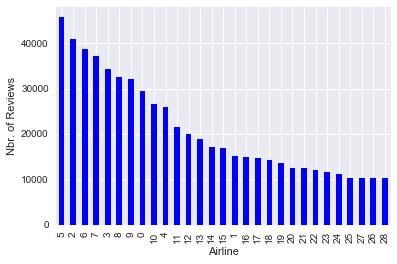

In [11]:
# Visualize reviews by airline, ordered by highest number
airline_df['airline_nbr_reviews'].sort_values(ascending=False).plot.bar(color='b')
plt.ylabel('Nbr. of Reviews')
plt.xlabel('Airline')
# revisit: change x axis labels


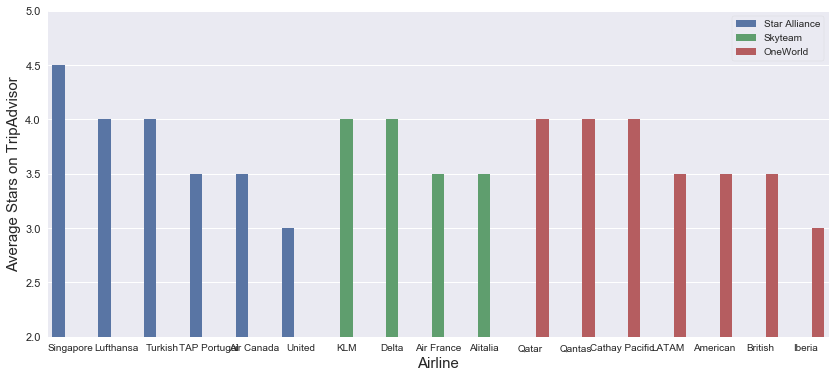

In [127]:
# Look into ratings of different airlines: Bar plot avg. star rating, by airline
# Good for managing partner airlines in alliance, for example

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 6))

# Plot the bars
sns.set_color_codes("pastel")
sns.barplot(x="airline_name_short", y="airline_stars"
            , data=airline_df.loc[airline_df['alliance']!='N/A'].sort_values(['alliance','airline_stars'], ascending=[False,False]) # remove airlines not in alliance
            #, data=airline_df.sort_values(['alliance','airline_stars'], ascending=[False,False]) # sort by alliance (incl. airlines not in alliance)
            , hue="alliance"
            # If want plot by budget, uncomment following two lines:
            #, data=airline_df.loc[airline_df['alliance']=='N/A'].sort_values(['alliance','airline_stars'], ascending=[False,False])
            #, hue="budget"
           )

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylim=(2, 5))
plt.xlabel("Airline", fontsize=15)
plt.ylabel("Average Stars on TripAdvisor", fontsize=15)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)
sns.despine(left=True, bottom=True)


([<matplotlib.axis.YTick at 0x1a135915c0>,
 <a list of 5 Text yticklabel objects>)

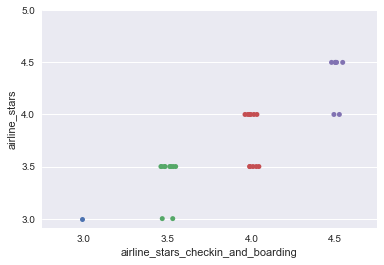

In [14]:
# Scatterplot of star sub-rating to total stars
# This one's nice b/c it's able to jitter the data
sns.stripplot(x='airline_stars_checkin_and_boarding', \
              y='airline_stars', data=airline_df, jitter=True)
plt.yticks(np.arange(min(airline_df['airline_stars']), \
                     max(airline_df['airline_stars'])+1, 0.5))


In [735]:
# Explore stats.pearsonr (R and p-value)
# Get the R value and p-value for stars on cleanliness vs. overall stars
print(stats.pearsonr(airline_df['airline_stars_cleanliness'], airline_df['airline_stars']))
print(stats.pearsonr(airline_df['airline_stars_cleanliness'], airline_df['airline_stars'])[0])
print(stats.pearsonr(airline_df['airline_stars_cleanliness'], airline_df['airline_stars'])[1])
# outputs R, p-value


(0.819956758793896, 9.357157008805496e-09)
0.819956758793896
9.357157008805496e-09


/Users/ctapen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/ctapen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/ctapen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/ctapen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/ctapen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning:

divide by zero encountered in true_divide

/Users/ctapen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning:

invalid value encounter

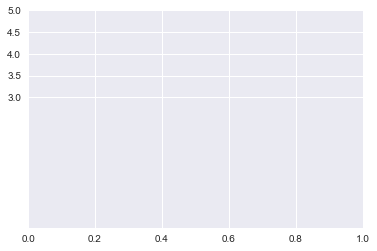

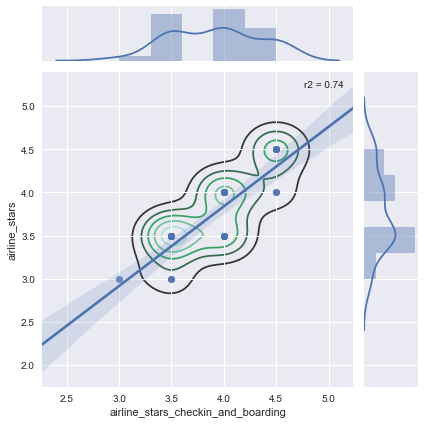

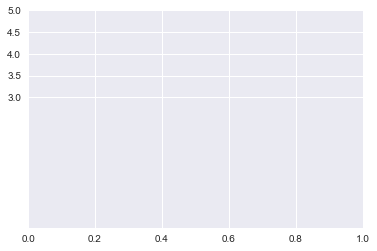

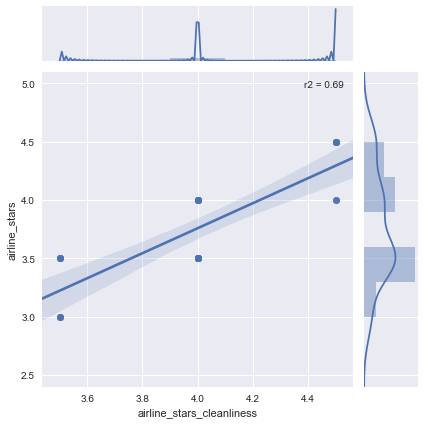

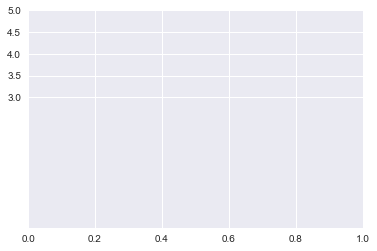

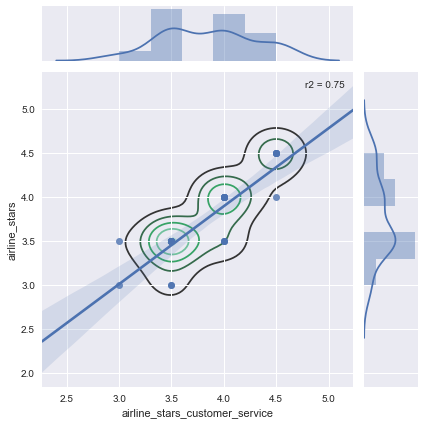

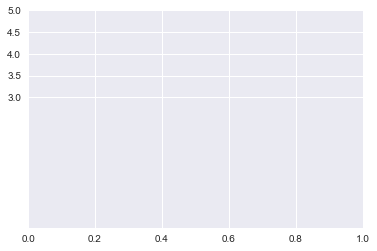

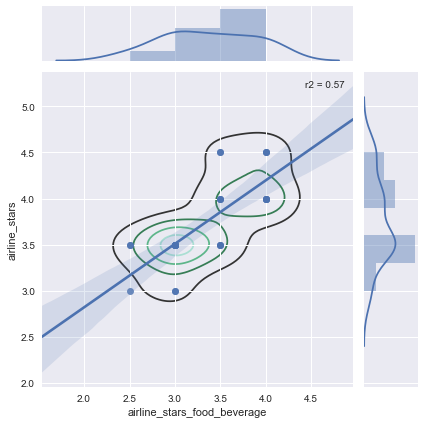

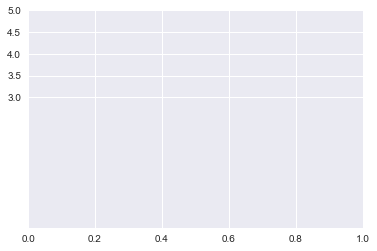

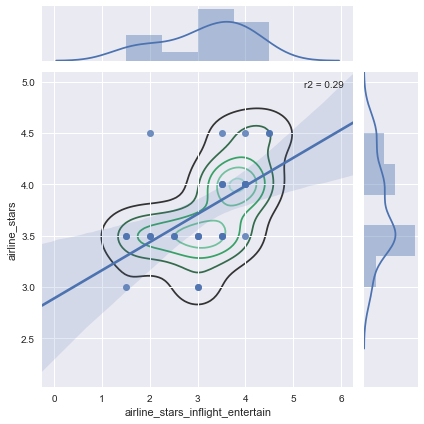

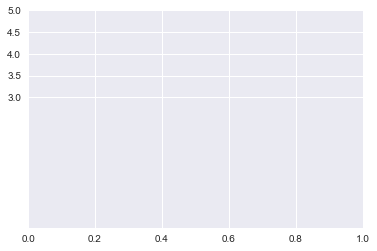

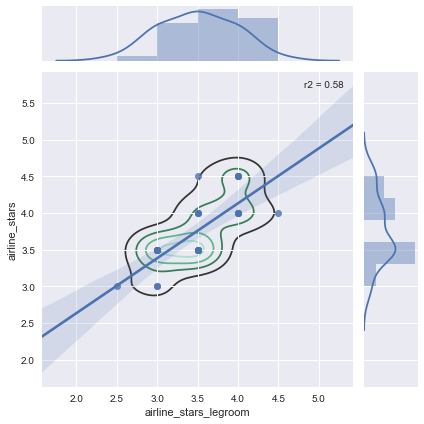

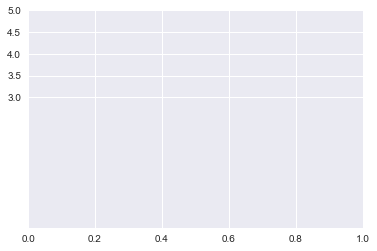

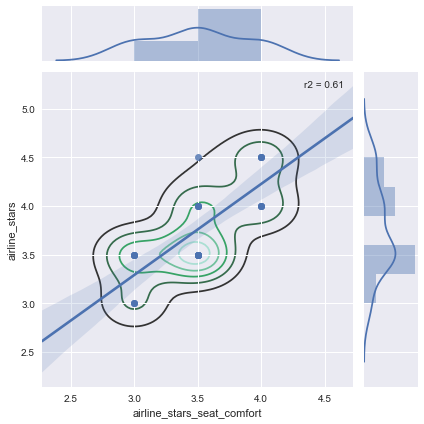

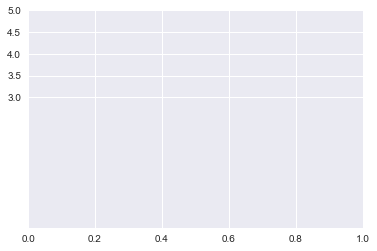

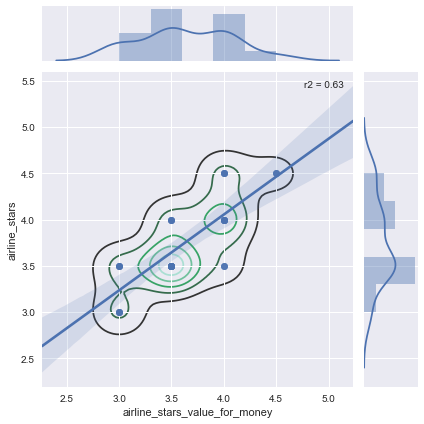

In [36]:
# Plot relationship for each sub-stars measure vs. overall stars

# Define functions for R, R^2, and p-value
def r(x, y):
    return stats.pearsonr(x, y)[0]
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
def p_value(x,y):
    return stats.pearsonr(x, y)[1]

# List all stars submeasures
submeasures = ['airline_stars_checkin_and_boarding', 
                   'airline_stars_cleanliness', 
                   'airline_stars_customer_service',
                   'airline_stars_food_beverage',
                   'airline_stars_inflight_entertain',
                   'airline_stars_legroom',
                   'airline_stars_seat_comfort',
                   'airline_stars_value_for_money']

# Define variables and create dictionary to output results to from loop
y_var = airline_df['airline_stars']
R2_dict = {}

# Loop through the submeasures and create plot for each with R^2
for submeasure in submeasures:
    plt.figure()
    plt.yticks(np.arange(min(y_var), max(y_var)+1, 0.5))
    # If want points jittered (no R^2):
    #sns.regplot(x=submeasure, \
    #              y='airline_stars', data=airline_df, x_jitter=0.07,y_jitter=0.07)#.set(xlim=(1.5, None))
    
    # If want with R^2 (no jitter):
    sns.jointplot(x=airline_df[submeasure], y=y_var, kind="reg", stat_func=r2)\
    .plot_joint(sns.kdeplot, zorder=0, n_levels=5)
    R2_dict[submeasure] = round(r2(airline_df[submeasure], airline_df['airline_stars']),3)#,
                           #'R': round(r(airline_df[submeasure], airline_df['airline_stars']),3),
                           #'p-value': p_value(airline_df[submeasure], airline_df['airline_stars'])
            #}

# ref for R^2: https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text

In [44]:
# R2 dictionary sorted on values and printed out
R2_dict = dict(sorted(R2_dict.items(), key=lambda x: x[1],reverse=True))
R2_dict

{'airline_stars_customer_service': 0.749,
 'airline_stars_checkin_and_boarding': 0.73799999999999999,
 'airline_stars_cleanliness': 0.69199999999999995,
 'airline_stars_value_for_money': 0.63,
 'airline_stars_seat_comfort': 0.60499999999999998,
 'airline_stars_legroom': 0.58099999999999996,
 'airline_stars_food_beverage': 0.56699999999999995,
 'airline_stars_inflight_entertain': 0.29299999999999998}

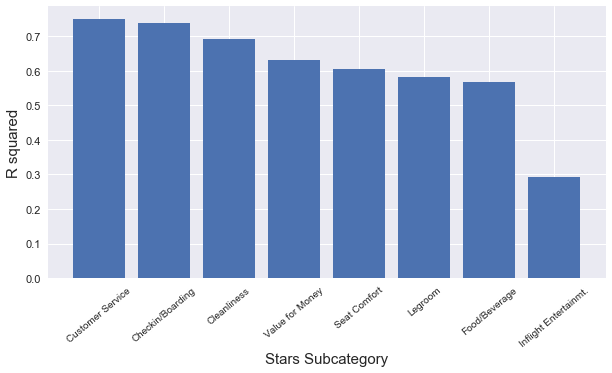

In [121]:
# Graph the R^2s by subcategory
f, ax = plt.subplots(figsize=(10, 5))
x_labels_list = list(R2_dict.keys())
x_labels_list_2 = ['Customer Service', 'Checkin/Boarding', 'Cleanliness', 'Value for Money', 'Seat Comfort', 'Legroom', 'Food/Beverage', 'Inflight Entertainmt.']

for i in range(len(x_labels_list)):
    x_labels_list[i] = x_labels_list[i].replace('airline_stars_','')
#print(list(R2_dict.keys()))
#print(x_labels_list)

plt.bar(range(len(R2_dict)), list(R2_dict.values()), align='center')
plt.xticks(range(len(R2_dict)), x_labels_list_2)
plt.xticks(rotation=40)
plt.xlabel("Stars Subcategory", fontsize=15)
plt.ylabel("R squared", fontsize=15)
plt.show()


### Big 4 Airlines Analysis (AA, DA, SW, UA)

In [52]:
# Filter to just 4 big U.S. airlines
df_big_four = df.loc[(df['big_four'] == 1)]
# Replace blank viaMobiles to notMobil
df_big_four.review_via_mobile = df_big_four.review_via_mobile.fillna('notMobile')
# Print head of df
df_big_four.head()


,airline_name,airline_nbr_reviews,airline_stars,airline_stars_checkin_and_boarding,airline_stars_cleanliness,airline_stars_customer_service,airline_stars_food_beverage,airline_stars_inflight_entertain,airline_stars_legroom,airline_stars_seat_comfort,airline_stars_value_for_money,record_nbr,review_ID,review_cabin_class,review_date,review_destination,review_domestic_intl,review_helpful_votes,review_origin,review_stars,review_text,review_title,review_travel_tip,review_via_mobile,reviewer_city,reviewer_country,reviewer_helpful_votes,reviewer_level,reviewer_name,reviewer_nbr_reviews,review_month,airline_name_short,big_four,url_nbr_tripadvisor,nbr_pages_scrape,country,airline_counter,alliance,budget
0,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602239156,Economy,2018-08-02,Newark,International,NaN,Sao Paulo,4.0,We flew economy plus. The ground crew was good...,Excellent Service at the gate and on the plane,NaN,notMobile,NaN,NaN,NaN,3.0,Nick M,11.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
1,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602237003,Economy,2018-08-02,Newark,International,NaN,Dublin,1.0,Absolutely zero customer service. No screens t...,Not impressed,NaN,viaMobile,Belfast,United Kingdom,13.0,3.0,Lynne K,18.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
2,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602235228,Economy,2018-08-02,Mexico City,Mexico,NaN,Los Angeles,4.0,No hitches. On time. Comfortable. There always...,Just fine,NaN,notMobile,NaN,NaN,NaN,NaN,hawk39,2.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
3,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602228223,Economy,2018-08-02,Detroit,USA,NaN,Ottawa,2.0,Arrived at the airport 4 for 6 am flight. Canc...,Cancelled two day in a row,NaN,notMobile,NaN,NaN,NaN,NaN,Liz E,2.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget
4,United Airlines,29345,3.0,3.5,3.5,3.5,3.0,3.0,3.0,3.0,3.0,NaN,602224401,Economy,2018-08-02,Newark,Domestic,NaN,Charlotte,1.0,It is abundantly clear that no person who work...,Avoid United Airlines At All Cost,NaN,viaMobile,River Vale,New Jersey,NaN,NaN,wjoshuala...,1.0,8,United,1,8729177,860,United States,2,Star Alliance,Not Budget


In [54]:
# Get count for each airline and each star rating
airline_by_rating = df_big_four.groupby(['airline_name_short', 'review_stars'])[['alliance']].count()

# Turn indexed airline_name_short and review_stars into columns
airline_by_rating.reset_index(level=0, inplace=True) 
airline_by_rating.reset_index(level=0, inplace=True) # do twice for review_stars and airline_name_short

# Rename column to count since that's what it's showing
airline_by_rating.rename(columns={'alliance': 'count'}, inplace=True)

airline_by_rating

,review_stars,airline_name_short,count
0,1.0,American,1735
1,2.0,American,1240
2,3.0,American,2209
3,4.0,American,3303
4,5.0,American,2964
5,1.0,Delta,653
6,2.0,Delta,579
7,3.0,Delta,1309
8,4.0,Delta,3039
9,5.0,Delta,4126


In [55]:
# Get average stars per airline
df_big_four.groupby(['airline_name_short'])[['review_stars']].agg({'mean','median'}).round(1)

review_stars     
                         median mean
airline_name_short                  
American                    4.0  3.4
Delta                       4.0  4.0
Southwest                   5.0  4.4
United                      4.0  3.3

In [57]:
# Get density for each airline and each star rating
airline_labels = ['American', 'Delta', 'Southwest', 'United']
# Pull data of interest
density_stars_by_airline = df_big_four.loc[df_big_four['airline_name_short'].isin(airline_labels)]\
.groupby(['airline_name_short', 'review_stars'])[['alliance']].count()

# Rename column to density
density_stars_by_airline.rename(columns={'alliance': 'density'}, inplace=True)

# Get density (pct of group instead of count)
density_stars_by_airline_2 = density_stars_by_airline.groupby(level=0)\
.apply(lambda x: 100 * x/float(x.sum()))

# Move the from index to column
density_stars_by_airline_2.reset_index(level=0, inplace=True) 
density_stars_by_airline_2.reset_index(level=0, inplace=True) 

density_stars_by_airline_2

,review_stars,airline_name_short,density
0,1.0,American,15.151515
1,2.0,American,10.828749
2,3.0,American,19.290892
3,4.0,American,28.844642
4,5.0,American,25.884202
5,1.0,Delta,6.727797
6,2.0,Delta,5.965382
7,3.0,Delta,13.486503
8,4.0,Delta,31.310530
9,5.0,Delta,42.509788


In [116]:
# Line graph of density of stars 1-5 by airline

# Create list to append into
data_big_four = []

# Iterate through the airlines
for airline in airline_labels:
    # Create traces for the airline ( a line/scatter each)
    data_big_four.append(go.Scatter(
        x = density_stars_by_airline_2.loc[density_stars_by_airline_2['airline_name_short']==airline]['review_stars'],
        y = round(density_stars_by_airline_2.loc[density_stars_by_airline_2['airline_name_short']==airline]['density'],1),
        mode = 'lines+markers',
        name = airline
    ))

# Assign data and plot
data = data_big_four
py.iplot(data, filename='line-mode')


In [65]:
# Stacked bar chart of reviews by airline

# Create variables
stars = [1.0, 2.0, 3.0, 4.0, 5.0]
data_big_four = []

# Iterate through the stars ratings
for star in stars:
    # Create bar per star rating per airline
    data_big_four.append(go.Bar(
        x = density_stars_by_airline_2.loc[density_stars_by_airline_2['review_stars']==star]['airline_name_short'],
        y = round(density_stars_by_airline_2.loc[density_stars_by_airline_2['review_stars']==star]['density'],1),
        name = int(star)
    ))
    
# Assign and print data
data = data_big_four
print(data)

# Set layout
layout = go.Layout(
    barmode='group',
    title='Stars Distribution by Airline',
    xaxis=dict(
        title='Airline',
        titlefont=dict(
            size=18
        )
    ),
    yaxis=dict(
        title='Percent of Reviews',
        titlefont=dict(
            size=18
        )
    )
)

# Create fig and plot
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')


[Bar({
    'name': '1',
    'x': array(['American', 'Delta', 'Southwest', 'United'], dtype=object),
    'y': array([ 15.2,   6.7,   3.1,  15.5])
}), Bar({
    'name': '2',
    'x': array(['American', 'Delta', 'Southwest', 'United'], dtype=object),
    'y': array([ 10.8,   6. ,   2.4,  12.7])
}), Bar({
    'name': '3',
    'x': array(['American', 'Delta', 'Southwest', 'United'], dtype=object),
    'y': array([ 19.3,  13.5,   7. ,  21.3])
}), Bar({
    'name': '4',
    'x': array(['American', 'Delta', 'Southwest', 'United'], dtype=object),
    'y': array([ 28.8,  31.3,  24.7,  28.7])
}), Bar({
    'name': '5',
    'x': array(['American', 'Delta', 'Southwest', 'United'], dtype=object),
    'y': array([ 25.9,  42.5,  62.8,  21.8])
})]


In [66]:
# Create boxplot per airline

# Create empty list
boxplot_data_airlines = []

# Loop through airlines to create box per airline
for airline in airline_labels:
    boxplot_data_airlines.append(go.Box(
        y=df_big_four.loc[df_big_four['airline_name_short']==airline]['review_stars'],
        name=airline
    ))

# Assign data, print, and plot
data = boxplot_data_airlines
print(data)
py.iplot(data)

[Box({
    'name': 'American', 'y': array([ 2.,  1.,  1., ...,  5.,  1.,  4.])
}), Box({
    'name': 'Delta', 'y': array([ 5.,  5.,  3., ...,  3.,  5.,  5.])
}), Box({
    'name': 'Southwest', 'y': array([ 3.,  5.,  5., ...,  5.,  4.,  4.])
}), Box({
    'name': 'United', 'y': array([ 4.,  1.,  4., ...,  3.,  4.,  5.])
})]


### By Mobile/Not Mobile (across big 4 airlines' data)

In [80]:
# By Mobile- freq, stars density

# Function for date formatting
def format_date(x):
    datetime.strptime(x, '%B %d, %Y').date()
# Test: format_date('August 2, 2018')

# Segment, group data, and produce counts by group
density_stars_by_mobile = df_big_four.loc[df_big_four['airline_name_short'].isin(airline_labels)].groupby(['review_via_mobile','review_stars'])[['alliance']].count()

# Rename column to density
density_stars_by_mobile.rename(columns={'alliance': 'density'}, inplace=True)

# Get density
density_stars_by_mobile_2 = density_stars_by_mobile.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))

# Change indices into columns
density_stars_by_mobile_2.reset_index(level=0, inplace=True)
density_stars_by_mobile_2.reset_index(level=0, inplace=True)

# Show data
density_stars_by_mobile_2


,review_stars,review_via_mobile,density
0,1.0,notMobile,7.663235
1,2.0,notMobile,7.894565
2,3.0,notMobile,16.372345
3,4.0,notMobile,30.705070
4,5.0,notMobile,37.364786
5,1.0,viaMobile,21.420940
6,2.0,viaMobile,8.867521
7,3.0,viaMobile,11.672009
8,4.0,viaMobile,19.457799
9,5.0,viaMobile,38.581731


In [82]:
# Bar plot by Stars by Mobile vs. Not Mobile

# Declare variables
stars = [1.0, 2.0, 3.0, 4.0, 5.0]
data_by_mobile = []

# Create first set of bars
data_by_mobile.append(go.Bar(
    x = stars, 
    y = round(density_stars_by_mobile_2.loc[density_stars_by_mobile_2['review_via_mobile']=='viaMobile']['density'],1),
    name = 'via Mobile',
    marker = dict(
          color = '#08519c'
        )
))

# Create second set of bars
data_by_mobile.append(go.Bar(
    x = stars, 
    y = round(density_stars_by_mobile_2.loc[density_stars_by_mobile_2['review_via_mobile']=='notMobile']['density'],1),
    name = 'not Mobile',
    marker = dict(
          color = '#6baed6'
        )
))    

# Assign data, print data    
data = data_by_mobile
print(data)

# Set layout
layout = go.Layout(
    barmode='group',
    title='Stars Distribution by Mobile Status',
    xaxis=dict(
        title='Stars, by Mobile Status',
        titlefont=dict(
            size=16
        )
    ),
    yaxis=dict(
        title='Percent of Reviews',
        titlefont=dict(
            size=16
        )
    ),
    font=dict(family='Arial')
)

# Assign figure and plot
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')


[Bar({
    'marker': {'color': '#08519c'},
    'name': 'via Mobile',
    'x': [1.0, 2.0, 3.0, 4.0, 5.0],
    'y': array([ 21.4,   8.9,  11.7,  19.5,  38.6])
}), Bar({
    'marker': {'color': '#6baed6'},
    'name': 'not Mobile',
    'x': [1.0, 2.0, 3.0, 4.0, 5.0],
    'y': array([  7.7,   7.9,  16.4,  30.7,  37.4])
})]


In [83]:
# View these one-star mobile reviews
one_star_mobile = df_big_four.loc[(df_big_four['review_stars']==1.0) & (df_big_four['review_via_mobile'] =='viaMobile')][['review_text']]
one_star_mobile.head()


,review_text
1,Absolutely zero customer service. No screens t...
4,It is abundantly clear that no person who work...
6,Wish the seats were stationery as your book en...
7,united deserves a zeroon 1/7/18 i booked a fam...
14,"Not only they are disrespectful, they are very..."


In [ ]:
# If more time, do basic NLP (word cloud, etc.) on review text...

In [84]:
# Density by review_via_mobile by month
density_stars_by_mobile_month = df_big_four.groupby(['review_month','review_via_mobile'])[['alliance']].count()

# Rename column to density
density_stars_by_mobile_month.rename(columns={'alliance': 'density'}, inplace=True)

# Get density
density_stars_by_mobile_month_2 = density_stars_by_mobile_month.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))

# Move indices to columns
density_stars_by_mobile_month_2.reset_index(level=0, inplace=True)
density_stars_by_mobile_month_2.reset_index(level=0, inplace=True)

# Drop month 8 (Aug) because only through ~Aug 2nd
density_stars_by_mobile_month_2 = density_stars_by_mobile_month_2[density_stars_by_mobile_month_2.review_month != 8]

# Print df
density_stars_by_mobile_month_2


,review_via_mobile,review_month,density
0,notMobile,1,84.501411
1,viaMobile,1,15.498589
2,notMobile,2,83.482506
3,viaMobile,2,16.517494
4,notMobile,3,84.932593
5,viaMobile,3,15.067407
6,notMobile,4,84.222246
7,viaMobile,4,15.777754
8,notMobile,5,76.791741
9,viaMobile,5,23.208259


In [85]:
# Line chart of % reviews via mobile over 2018 months

# Declare variables
review_mobile_opts = ['viaMobile'] #, 'notMobile' - second line didn't add anything b/c 100% - other line
data_mobile_month = []

# Iterate through review_mobile_opts
for review_mobile in review_mobile_opts:
    # Create traces
    data_mobile_month.append(go.Scatter(
        x = density_stars_by_mobile_month_2.loc[density_stars_by_mobile_month_2['review_via_mobile']==review_mobile]['review_month'],
        y = round(density_stars_by_mobile_month_2.loc[density_stars_by_mobile_month_2['review_via_mobile']==review_mobile]['density'],1),
        mode = 'lines+markers',
        name = review_mobile
    ))

# Set layout
layout = go.Layout(
    autosize=False,
    width=650,
    height=400,
    title='Percent of Reviews Over Time by Mobile',
    xaxis=dict(
        title='Months, 2018',
        titlefont=dict(
            size=16
        )
    ),
    yaxis=dict(
        title='Percent of Reviews',
        titlefont=dict(
            size=16
        ),
        range=[10, 32] # set the range so more logical zoom
    ),
    font=dict(family='Arial')
)

# Define data and fig, then plot
data = data_mobile_month
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='line-mode')


### By Airport (across big 4 airlines' data)

In [86]:
# Get count and mean for each origin airport (across big 4 airlines)

# Get stars per origin airport and make review_origin column not an index
avg_stars_by_airport = df_big_four.groupby(['review_origin'])[['review_stars']]\
.describe().reset_index()

# Create data frame from dictionary of review_origin, count, and mean
airport_df = pd.DataFrame(
    {'review_origin': avg_stars_by_airport['review_origin'],
     'count': avg_stars_by_airport['review_stars']['count'],
     'mean': avg_stars_by_airport['review_stars']['mean']
    })

# Show data top 30 on count and sort on mean descending
airport_df.sort_values('count', ascending=False).head(30).sort_values('mean',ascending=False)

# Note: some cities have more than one airport (NYC, DC)


,review_origin,count,mean
317,Nashville,379.0,4.174142
33,Baltimore,707.0,4.159830
220,Kansas City,360.0,4.147222
357,Pittsburgh,336.0,4.145833
454,Tampa,654.0,4.062691
122,Detroit,748.0,4.054813
24,Atlanta,1325.0,4.044528
290,Minneapolis,641.0,4.023401
393,Saint Louis,399.0,4.020050
151,Fort Lauderdale,476.0,4.014706


In [90]:
# Add data for Airports' latitude and longitude so can map ratings by airport
airports_lat_long = [
['index', 'airport_city', 'count', 'mean', 'airport_code', 'airport_icao_code', 'lat', 'long'], 
[317, 'Nashville', 379, 4.174142, 'BNA', 'KBNA', 36.1245003, -86.6781998], 
[33, 'Baltimore', 707, 4.15983, 'BWI', 'KBWI', 39.1753998, -76.6682968], 
[220, 'Kansas City', 360, 4.147222, 'MCI', 'KMCI', 39.2975998, -94.7138977], 
[357, 'Pittsburgh', 336, 4.145833, 'PIT', 'KPIT', 40.4915009, -80.2329025], 
[454, 'Tampa', 654, 4.062691, 'TPA', 'KTPA', 27.9755001, -82.5332031], 
[122, 'Detroit', 748, 4.054813, 'DMW', 'KDMW', 42.2123985, -833534012], 
[24, 'Atlanta', 1325, 4.044528, 'ATL', 'KATL', 33.6366997, -84.4281006], 
[290, 'Minneapolis', 641, 4.023401, 'MSP', 'KMSP', 44.882, -93.2218018], 
[393, 'Saint Louis', 399, 4.02005, 'STL', 'KSTL', 38.7486992, -90.3700027], 
[151, 'Fort Lauderdale', 476, 4.014706, 'FLL', 'KFLL', 26.0725994, -80.1527023], 
[341, 'Orlando', 740, 3.847297, 'MCO', 'KMCO', 28.4293995, -81.3089981], 
[356, 'Phoenix', 842, 3.82304, 'PHX', 'KPHX', 33.4342995, -112.012001], 
[119, 'Denver', 864, 3.820602, 'DEN', 'KDEN', 39.8616982, -104.6729965], 
[241, 'Las Vegas', 634, 3.815457, 'LAS', 'KLAS', 36.080101, -115.1520004], 
[363, 'Portland', 379, 3.804749, 'PDX', 'KPDX', 45.5886993, -122.5979996], 
[115, 'Dallas', 1187, 3.795282, 'DAL', 'KDAL', 32.8470993, -96.851799], 
[97, 'Chicago', 1541, 3.778715, 'ORD', 'KORD', 41.9785996, -87.9048004], 
[400, 'San Diego', 342, 3.777778, 'SAN', 'KSAN', 32.7336006, -117.1900024], 
[202, 'Houston', 832, 3.757212, 'IAH', 'KIAH', 29.9843998, -95.2414001], 
[254, 'London', 590, 3.686441, 'LHR', 'EGLL', 51.4706001, -0.461941], 
[257, 'Los Angeles', 1355, 3.577122, 'LAX', 'KLAX', 33.9425011, -118.4079971], 
[323, 'New York City', 1386, 3.566378, 'JFK', 'KJFK', 40.63801, -73.7789002], 
[423, 'Seattle', 481, 3.561331, 'SEA', 'KSEA', 47.4490013, -122.3089981], 
[60, 'Boston', 620, 3.559677, 'BOS', 'KBOS', 42.3642998, -71.0052033], 
[478, 'Washington DC', 828, 3.549517, 'DCA', 'KDCA', 38.8521004, -77.0376968], 
[93, 'Charlotte', 555, 3.542342, 'CLT', 'KCLT', 35.2140007, -80.9431], 
[355, 'Philadelphia', 858, 3.494172, 'PHL', 'KPHL', 39.8718987, -75.2410965], 
[401, 'San Francisco', 787, 3.400254, 'SFO', 'KSFO', 37.6189995, -122.375], 
[324, 'Newark', 1258, 3.357711, 'EWR', 'KEWR', 40.6925011, -74.1687012], 
[286, 'Miami', 735, 3.314286, 'MIA', 'KMIA', 25.7931995, -80.2906036]
]


In [93]:
airports_lat_long = pd.DataFrame(airports_lat_long[1:],columns=airports_lat_long[0])
airports_lat_long

,index,airport_city,count,mean,airport_code,airport_icao_code,lat,long
0,317,Nashville,379,4.174142,BNA,KBNA,36.124500,-8.667820e+01
1,33,Baltimore,707,4.159830,BWI,KBWI,39.175400,-7.666830e+01
2,220,Kansas City,360,4.147222,MCI,KMCI,39.297600,-9.471390e+01
3,357,Pittsburgh,336,4.145833,PIT,KPIT,40.491501,-8.023290e+01
4,454,Tampa,654,4.062691,TPA,KTPA,27.975500,-8.253320e+01
5,122,Detroit,748,4.054813,DMW,KDMW,42.212398,-8.335340e+08
6,24,Atlanta,1325,4.044528,ATL,KATL,33.636700,-8.442810e+01
7,290,Minneapolis,641,4.023401,MSP,KMSP,44.882000,-9.322180e+01
8,393,Saint Louis,399,4.020050,STL,KSTL,38.748699,-9.037000e+01
9,151,Fort Lauderdale,476,4.014706,FLL,KFLL,26.072599,-8.015270e+01


In [123]:
# Create a map in plotly of star ratings by originating airport

# Set up data with lat/long/text/color scale
data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = airports_lat_long['long'],
        lat = airports_lat_long['lat'],
        text = airports_lat_long['airport_city'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            #colorscale = scl,
            cmin = airports_lat_long['mean'].min(),
            color = airports_lat_long['mean'],
            cmax = airports_lat_long['mean'].max(),
            colorbar=dict(
                title="Avg. Flight Rating"
            )
        ))]

# Set layout
layout = dict(
        title = 'Flight Reviews, by Originating Airport<br>(Hover for airport names)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(206, 202, 202)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

# Declare dif and plot
fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-airports' )

# ref: https://plot.ly/python/scatter-plots-on-maps/

### By Reviewers' Nbr. of Reviews

In [95]:
# Star rating distribution by high # reviewers vs. low

# Get data
density_stars_by_reviewer_level = df_big_four.groupby(['reviewer_level','review_stars'])[['alliance']].count()

# Rename column to density and get density
density_stars_by_reviewer_level.rename(columns={'alliance': 'density'}, inplace=True)
density_stars_by_reviewer_level_2 = density_stars_by_reviewer_level.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))

# Make indices into columns
density_stars_by_reviewer_level_2.reset_index(level=0, inplace=True)
density_stars_by_reviewer_level_2.reset_index(level=0, inplace=True)

# Return df
density_stars_by_reviewer_level_2


,review_stars,reviewer_level,density
0,1.0,1.0,15.281899
1,2.0,1.0,9.198813
2,3.0,1.0,10.459941
3,4.0,1.0,23.738872
4,5.0,1.0,41.320475
5,1.0,2.0,11.327561
6,2.0,2.0,7.816258
7,3.0,2.0,12.193362
8,4.0,2.0,25.877826
9,5.0,2.0,42.784993


In [96]:
# Line graph of star density by review level of reviewer

# Declare variables
review_levels = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
data_review_level = []

# Iterate through the review_levels
for review_level in review_levels:
    # Create traces
    data_review_level.append(go.Scatter(
        x = density_stars_by_reviewer_level_2.loc[density_stars_by_reviewer_level_2['reviewer_level']==review_level]['review_stars'],
        y = round(density_stars_by_reviewer_level_2.loc[density_stars_by_reviewer_level_2['reviewer_level']==review_level]['density'],1),
        mode = 'lines+markers',
        name = review_level
    ))

# Declare data and plot
data = data_review_level
py.iplot(data, filename='line-mode')

# output: so doesn't vary considerably by review level
